In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.stats
import scipy.optimize
import scipy.integrate

# Neyman belt for Gaussian
- $x \sim \mathcal N (\mu, 1)$
- measure statistic $t = x$ (single measurement)
- generate 2-dim histogram for $x \in [0, 10]$ and $\mu \in [0, 20]$
- for each value of $\mu$ populate hist “row” with $10^5$ samples for $x$
- for a measurement $x = 5$, invert the confidence belt and find the confidence interval

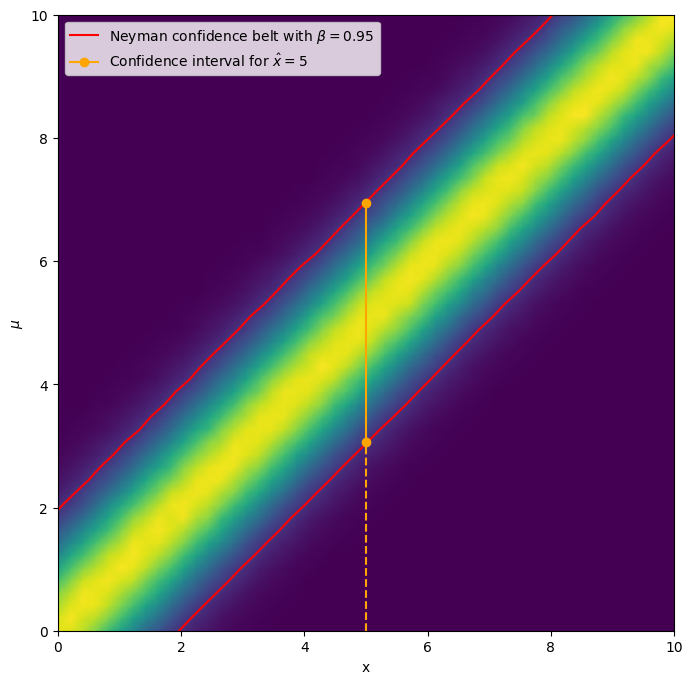

In [57]:
beta = 0.95

x_min = 0
x_max = 10
x_bin_count = 50
x_bin_size = (x_max - x_min) / x_bin_count
x_bin_edges = np.linspace(
    x_min - x_bin_size / 2, x_max + x_bin_size / 2, x_bin_count + 1
)
x_range = np.linspace(x_min, x_max, x_bin_count)

mu_range = np.linspace(0, 10, 50)

map_ = np.zeros(shape=(len(x_range), len(mu_range)))

lower_mu_q: list[float] = []
upper_mu_q: list[float] = []
for j, mu in enumerate(mu_range):
    sample = np.random.normal(loc=mu, scale=1, size=100_000)
    lower_mu_q.append(np.quantile(sample, q=(1 - beta) / 2))
    upper_mu_q.append(np.quantile(sample, q=1 - (1 - beta) / 2))
    map_[:, j] = np.histogram(sample, bins=x_bin_edges)[0]

lower_mu_q = np.array(lower_mu_q)
upper_mu_q = np.array(upper_mu_q)

x_measured = 5
mu_upper = mu_range[np.argmin(np.abs(lower_mu_q - x_measured))]
mu_lower = mu_range[np.argmin(np.abs(upper_mu_q - x_measured))]

fig, ax = plt.subplots(figsize=(8, 8))

ax.pcolormesh(x_range, mu_range, map_.T, shading="gouraud")
ax.plot(lower_mu_q, mu_range, "r")
ax.plot(
    upper_mu_q, mu_range, "r", label=f"Neyman confidence belt with $ \\beta = {beta} $"
)
ax.add_line(
    Line2D(
        [x_measured, x_measured],
        [mu_range[0], mu_lower],
        color="orange",
        linestyle="--",
    )
)
ax.add_line(
    Line2D(
        [x_measured, x_measured],
        [mu_lower, mu_upper],
        color="orange",
        marker="o",
        label=f"Confidence interval for $ \\hat x = {x_measured} $",
    )
)
ax.set_xlim(0, 10)
ax.set_xlabel("x")
ax.set_ylabel("$ \\mu $")
ax.set_aspect("equal", "box")
ax.legend()
plt.show()

# Neyman belt for Binomial
- assume we inject $n$ artificial event into the detector and want to measure it’s trigger efficiency $p$
- take $n = 10$ and $p = \{ 0, 10^{-3}, 2 \cdot 10^{-3}, ..., 1 \}$
- create 2-dim histogram for $k, p$ with $k \in [0, n]$
- for each value of $p$ populate hist “row” with $10^5$ samples for $k$
- $\forall p$ extract the $68\%$ shortest interval and plot the Neyman belt
- compute and plot the (over)coverage or $p$

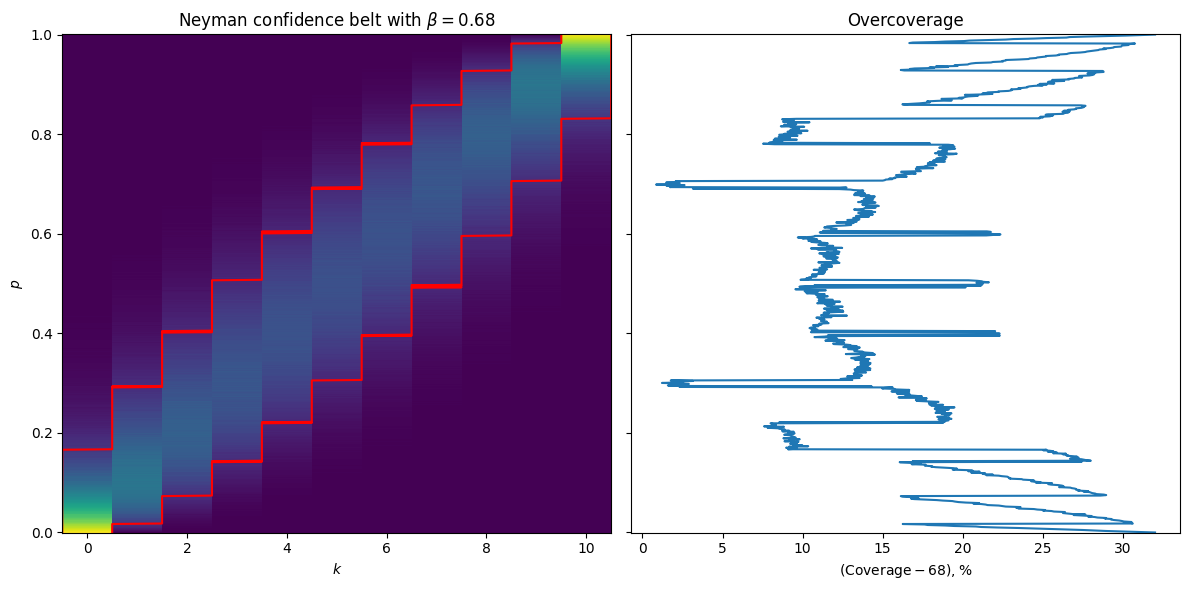

In [80]:
beta = 0.68

n = 10

k_min = 0
k_max = n
k_range = np.arange(k_min, k_max + 1)
k_bin_edges = np.arange(k_min - 0.5, k_max + 1.5)

p_range = np.linspace(0, 1, 1000)

map_ = np.zeros(shape=(len(k_range), len(p_range)))

lower_p_q: list[float] = []
upper_p_q: list[float] = []
coverage: list[float] = []
for j, p in enumerate(p_range):
    sample_size = 10_000
    k_sample = scipy.stats.binom.rvs(n=n, p=p, size=sample_size)
    lower = np.quantile(k_sample, q=(1 - beta) / 2) - 0.5
    upper = np.quantile(k_sample, q=1 - (1 - beta) / 2) + 0.5
    lower_p_q.append(lower)
    upper_p_q.append(upper)
    coverage.append(
        np.sum(np.logical_and(lower <= k_sample, k_sample <= upper)) / sample_size
    )
    map_[:, j] = np.histogram(k_sample, bins=k_bin_edges)[0]

lower_p_q = np.array(lower_p_q)
upper_p_q = np.array(upper_p_q)
coverage = np.array(coverage)

fig, (ax_belt, ax_coverage) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

ax_belt.pcolormesh(k_range, p_range, map_.T)
ax_belt.plot(lower_p_q, p_range, "r")
ax_belt.plot(upper_p_q, p_range, "r")
ax_belt.set_xlabel("$ k $")
ax_belt.set_ylabel("$ p $")
ax_belt.set_title(f"Neyman confidence belt with $ \\beta = {beta} $")

ax_coverage.plot(100 * (coverage - beta), p_range)
ax_coverage.set_xlabel(f"$ (\\mathrm{{Coverage}} - {beta * 100:.0f}), \% $")
ax_coverage.set_title("Overcoverage")

plt.tight_layout()
plt.show()

## Flip-flopping problem
- take $x \sim \mathcal N (\mu, 1)$
- suppose physical constraint of $\mu > 0$
- suppose we measure $x$ with an instrument subject to fluctuations and measured value can be negative
- we decide to report the following as our best estimate:
	- if $x > 3$ → $\hat \mu = x$ and central 90% C.I.
	- if $x < 3$ → $\hat \mu = 0$ and upper bound 90% C.I.
- plot coverage in this case


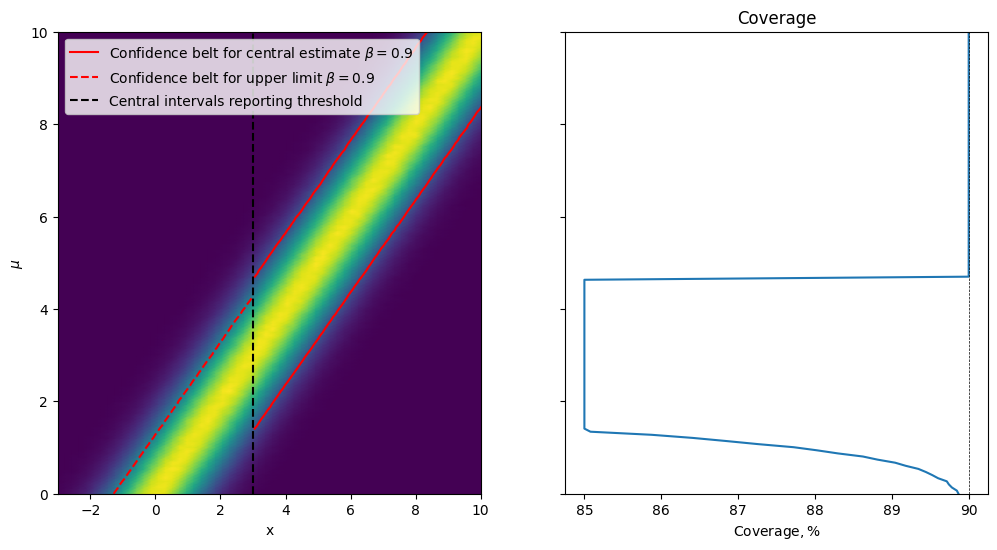

In [79]:
beta = 0.90

x_min = -3
x_max = 10
x_bin_count = 60
x_bin_size = (x_max - x_min) / x_bin_count
x_bin_edges = np.linspace(
    x_min - x_bin_size / 2, x_max + x_bin_size / 2, x_bin_count + 1
)
x_range = np.linspace(x_min, x_max, x_bin_count)

mu_range = np.linspace(0, 10, 150)

map_ = np.zeros(shape=(len(x_range), len(mu_range)))

central_lower_mu_q: list[float] = []
central_upper_mu_q: list[float] = []
lower_mu_q: list[float] = []
coverage: list[float] = []
for j, mu in enumerate(mu_range):
    sample_size = 100_000
    sample = np.random.normal(loc=mu, scale=1, size=sample_size)
    cl = np.quantile(sample, q=(1 - beta) / 2)
    cu = np.quantile(sample, q=1 - (1 - beta) / 2)
    l = np.quantile(sample, q=1 - beta)
    central_lower_mu_q.append(cl)
    central_upper_mu_q.append(cu)
    lower_mu_q.append(l)
    coverage.append(
        np.sum(np.logical_and((cl if cl > 3 else l) <= sample, sample <= max(cu, 3)))
        / sample_size
    )
    map_[:, j] = np.histogram(sample, bins=x_bin_edges)[0]
central_lower_mu_q = np.array(central_lower_mu_q)
central_upper_mu_q = np.array(central_upper_mu_q)
lower_mu_q = np.array(lower_mu_q)
coverage = np.array(coverage)

fig, (ax_belt, ax_coverage) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

central_thrsh = 3
ax_belt.pcolormesh(x_range, mu_range, map_.T, shading="gouraud")
ax_belt.plot(
    central_lower_mu_q[central_lower_mu_q > central_thrsh],
    mu_range[central_lower_mu_q > central_thrsh],
    "r",
)
ax_belt.plot(
    central_upper_mu_q[central_upper_mu_q > central_thrsh],
    mu_range[central_upper_mu_q > central_thrsh],
    "r",
    label=f"Confidence belt for central estimate $ \\beta = {beta} $",
)
ax_belt.plot(
    lower_mu_q[lower_mu_q < central_thrsh],
    mu_range[lower_mu_q < central_thrsh],
    "r",
    linestyle="--",
    label=f"Confidence belt for upper limit $ \\beta = {beta} $",
)
ax_belt.axvline(
    central_thrsh,
    color="k",
    linestyle="--",
    label="Central intervals reporting threshold",
)
ax_belt.set_xlabel("x")
ax_belt.set_ylabel("$ \\mu $")
ax_belt.set_xlim(x_min, x_max)
ax_belt.legend()

ax_coverage.plot(100 * coverage, mu_range)
ax_coverage.set_xlabel("$ \\mathrm{Coverage}, \% $")
ax_coverage.axvline(100 * beta, color="k", linestyle="--", linewidth=0.5)
ax_coverage.set_title("Coverage")

plt.show()

# Feldman-Cousins intervals for Gaussian distribution
- take $x \sim \mathcal N (\mu, 1)$
- consider $x \in [-3, 11]$ and non-negative $\mu$
- prepare a histogram with $x \in [-3, 11]$, $\mu \in [0, 7]$
- plot best-estimate $\hat \mu(x)$ ($\max_\mu(f(x | \mu))$)
- construct FC belt for $\beta = 90\%$
- compare with toy Monte-Carlo:
	- generate $10^4$ values of every $\mu$ value
	- for every $\mu$ compute the fraction of the sample falling into the confidence belt

/Users/njvh/Documents/Science/GSSI/STAT/venv/lib/python3.11/site-packages/scipy/optimize/_zeros_py.py:364: RuntimeWarning: Tolerance of 0.11765781224742873 reached.
  warnings.warn(msg, RuntimeWarning)


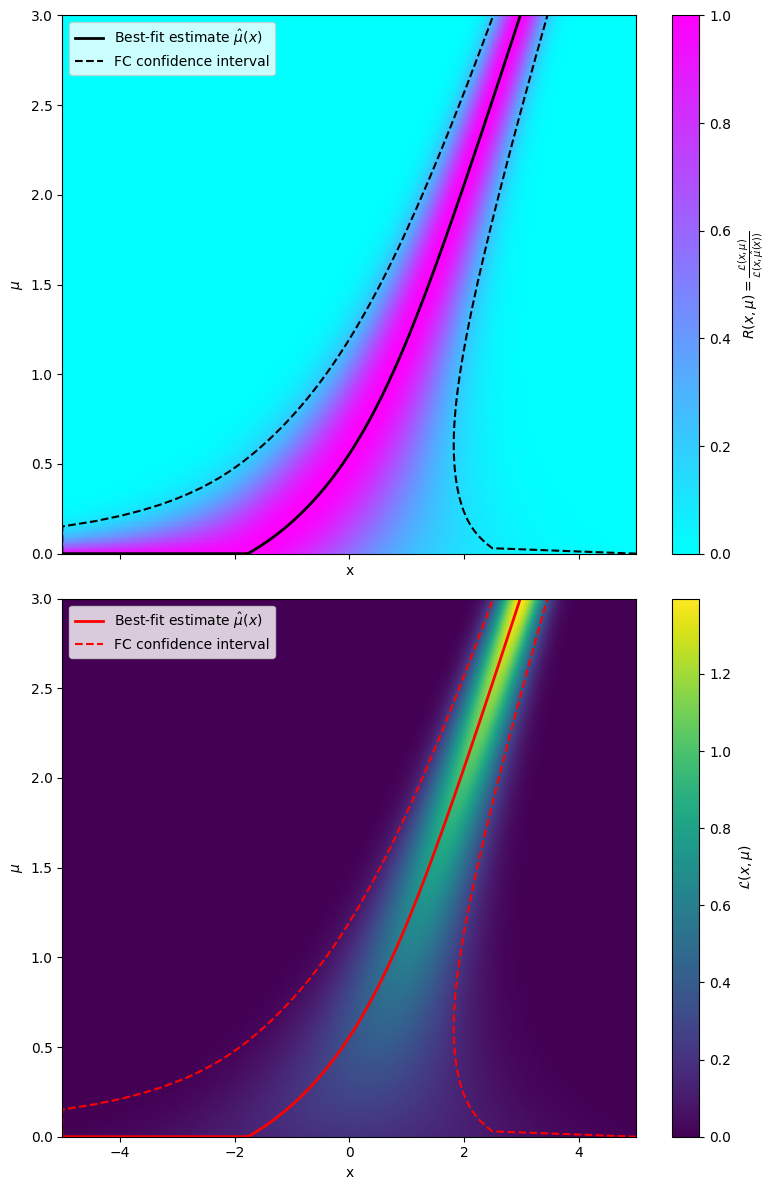

In [42]:
beta = 0.90


def likelihood(mu: float, x: float) -> float:
    # return scipy.stats.skewnorm.pdf(x, loc=mu, scale=1.5, a=-6)
    return scipy.stats.norm.pdf(x, loc=mu, scale=1 / (0.5 + mu))


x_range = np.linspace(-5, 5, 200)
mu_range = np.linspace(0, 3, 100)

# find best-fitting mu
mu_best_fit = []
likelihood_best_fit = []
for x in x_range:
    negloglike = lambda mu: -np.log(likelihood(mu, x))
    mu_best_fit_search_res = scipy.optimize.minimize(
        negloglike, [x], bounds=scipy.optimize.Bounds(0, np.inf)
    )
    mu_best_fit.append(mu_best_fit_search_res.x)
    likelihood_best_fit.append(likelihood(mu_best_fit_search_res.x, x)[0])
mu_best_fit = np.array(mu_best_fit)
likelihood_best_fit = np.array(likelihood_best_fit)

# fill R map

R_map = np.zeros(shape=(len(x_range), len(mu_range)))
L_map = np.zeros(shape=(len(x_range), len(mu_range)))

lower_fc = []
upper_fc = []
for j, mu in enumerate(mu_range):
    L_on_x_range = likelihood(mu, x_range)
    R_on_x_range = L_on_x_range / likelihood_best_fit
    R_map[:, j] = R_on_x_range
    L_map[:, j] = L_on_x_range

    # determine FC bounds
    i_max = np.argmax(R_on_x_range)
    x_R_max = x_range[i_max]
    R_fn = lambda x: np.interp(x, x_range, R_on_x_range)

    def fc_interval(R_level: float) -> tuple[float, float]:
        delta_R = lambda x: R_fn(x) - R_level
        low_approx = (
            (x_range[:i_max])[np.argmin(np.abs(R_on_x_range[:i_max] - R_level))]
            if i_max > 0
            else x_range[0]
        )
        high_approx = (x_range[i_max:])[
            np.argmin(np.abs(R_on_x_range[i_max:] - R_level))
        ]
        low = scipy.optimize.newton(delta_R, low_approx, disp=False)
        high = scipy.optimize.newton(delta_R, high_approx, disp=False)
        return low, high

    def delta_prob(R_level: float) -> float:
        low, high = fc_interval(R_level)
        res = beta - scipy.integrate.quad(lambda x: likelihood(mu, x), low, high)[0]
        # print(R_level, "->", (low, high), "->", res)
        return res

    R_level = scipy.optimize.newton(delta_prob, 0.5, disp=False)
    lower, upper = fc_interval(R_level)
    lower_fc.append(lower)
    upper_fc.append(upper)

lower_fc = np.array(lower_fc)
upper_fc = np.array(upper_fc)

fig, (ax, ax2) = plt.subplots(nrows=2, figsize=(8, 12), sharex=True, sharey=True)

for ax, map_, cmap, color_label, line_color in [
    (
        ax,
        R_map,
        "cool",
        "$ R (x, \\mu) = \\frac { \\mathcal{L} (x, \\mu) }{ \\mathcal{L} (x, \\hat \\mu (x))} $",
        "k",
    ),
    (
        ax2,
        L_map,
        "viridis",
        "$ \\mathcal{L} (x, \\mu) $",
        "r",
    ),
]:
    mesh = ax.pcolormesh(x_range, mu_range, map_.T, shading="gouraud", cmap=cmap)
    ax.plot(
        x_range,
        mu_best_fit,
        line_color,
        linewidth=2,
        label="Best-fit estimate $ \\hat \\mu (x) $",
    )
    ax.plot(lower_fc, mu_range, line_color, linestyle="--")
    ax.plot(upper_fc, mu_range, line_color, linestyle="--", label="FC confidence interval")

    ax.set_xlabel("x")
    ax.set_ylabel("$ \\mu $")
    ax.set_ylim(mu_range[0], mu_range[-1])
    ax.set_xlim(x_range[0], x_range[-1])
    ax.legend()
    plt.colorbar(
        mesh,
        label=color_label,
    )

plt.tight_layout()
plt.show()